In [1]:
import xarray as xr
import pandas as pd
# 使用open_dataset函数打开NetCDF文件
data = xr.open_dataset("/home/rice/cosipy/data/output/kqgr_test_20210607-20240925.nc")


In [ ]:
data.sum(dim='time') 

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from shapely.geometry import box

# 对 2022 和 2023 年的数据分别求和
plot = data.sum(dim='time')

# 提取相关数据
lat22 = plot['lat'].values  # 2022年纬度
lon22 = plot['lon'].values  # 2022年经度
MB22 = plot['MB'].values  # 2022年温度数据（单位：°C）


# 将值为 0 的地方设置为空
MB22[MB22 ==0] = np.nan

# 加载 Shapefile
shp_path = "/home/rice/cosipy/data/static/Shapefiles/KQGR.shp"  # 替换为您的 .shp 文件路径
shapefile = Reader(shp_path)
shapefile_feature = ShapelyFeature(shapefile.geometries(), ccrs.PlateCarree(), edgecolor='black', facecolor='none')

# 计算 Shapefile 的边界范围
geometries = list(shapefile.geometries())
bounds = box(*geometries[0].bounds)  # 取第一个几何体的边界
for geom in geometries[1:]:
    bounds = bounds.union(box(*geom.bounds))  # 合并几何体的边界范围
min_lon, min_lat, max_lon, max_lat = bounds.bounds  # 提取边界坐标

# 创建一个 2x2 的子图（两行两列）
fig, axes = plt.subplots(1, 1, figsize=(15, 12), subplot_kw={'projection': ccrs.PlateCarree()})

# 绘制 2022 年的 MB分布图
ax1 = axes
mesh1 = ax1.pcolormesh(lon22, lat22, MB22, cmap='coolwarm', transform=ccrs.PlateCarree(), shading='auto', edgecolors='black', linewidth=0.2)
fig.colorbar(mesh1, ax=ax1, label="MB (m)")
ax1.add_feature(shapefile_feature, linewidth=1)
ax1.set_extent([min_lon - 0.0005, max_lon + 0.0005, min_lat - 0.0005, max_lat + 0.0005], crs=ccrs.PlateCarree())
ax1.set_title('2022 MB Distribution')


# 调整布局
plt.tight_layout()

# 显示图像
plt.show()


: 

In [2]:
plot_data = data.mean(dim=['lat','lon']).to_dataframe().reset_index()

# 假设 df 是你的 DataFrame，包含所有这些列
# 定义需要求和和求平均的变量
sum_vars = [
    'RRR', 'SNOWFALL', 'RAIN', 'EVAPORATION', 'SUBLIMATION', 
    'CONDENSATION', 'DEPOSITION', 'REFREEZE', 'subM', 'surfM', 
    'surfMB', 'MB','intMB'
]

mean_vars = [
    'T2', 'LWin', 'H', 'LE', 'B','ALBEDO','LWout','TS', 'G','ME'
]

# 为 DataFrame 中的列指定不同的聚合方法
agg_dict = {var: 'sum' for var in sum_vars}
agg_dict.update({var: 'mean' for var in mean_vars})

# 示例：假设你已经有一个 DataFrame df，并且 TIMESTAMP 列是时间戳
plot_data['time'] = pd.to_datetime(plot_data['time'])  # 确保 TIMESTAMP 列是 datetime 类型

# 按小时进行重采样，并使用不同的聚合方法
df_hour = plot_data.resample('H', on='time').agg(agg_dict).reset_index()
df_month = plot_data.resample('M', on='time').agg(agg_dict).reset_index()
df_day = plot_data.resample('D', on='time').agg(agg_dict).reset_index()
df_year = plot_data.resample('Y', on='time').agg(agg_dict).reset_index()

# 提取年月并创建新的列
df_month['year_month'] = df_month['time'].dt.to_period('M')
df_month['year_month'] = df_month['year_month'].dt.strftime('%Y-%m')

# 提取年月并创建新的列
df_year['year'] = df_year['time'].dt.to_period('Y')
df_year['year'] = df_year['year'].dt.strftime('%Y')

: 

In [4]:
import xarray as xr
era5_data = xr.open_dataset("/home/rice/cosipy/data/input/ERA5/ERA5_2000.nc")


In [5]:
era5_data

<xarray.Dataset> Size: 83MB
Dimensions:  (lon: 14, lat: 12, time: 8776)
Coordinates:
  * lon      (lon) float64 112B 90.19 90.19 90.19 90.19 ... 90.2 90.2 90.2 90.2
  * lat      (lat) float64 96B 29.86 29.86 29.86 29.86 ... 29.87 29.87 29.87
  * time     (time) datetime64[ns] 70kB 2000-01-01T08:00:00 ... 2000-12-31T23...
Data variables:
    HGT      (lat, lon) float32 672B ...
    ASPECT   (lat, lon) float32 672B ...
    SLOPE    (lat, lon) float32 672B ...
    MASK     (lat, lon) float32 672B ...
    T2       (time, lat, lon) float64 12MB ...
    RH2      (time, lat, lon) float64 12MB ...
    U2       (time, lat, lon) float64 12MB ...
    G        (time, lat, lon) float64 12MB ...
    PRES     (time, lat, lon) float64 12MB ...
    RRR      (time, lat, lon) float64 12MB ...
    LWin     (time, lat, lon) float64 12MB ...

In [ ]:
df_year['MB']

0   -10.237647
Name: MB, dtype: float64

In [ ]:
df_month[['year_month','MB']]

,year_month,MB
0,2000-01,0.006204
1,2000-02,0.007699
2,2000-03,0.020003
3,2000-04,0.027684
4,2000-05,-1.079716
5,2000-06,-3.168278
6,2000-07,-1.572483
7,2000-08,-1.657575
8,2000-09,-1.955566
9,2000-10,-0.870059


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

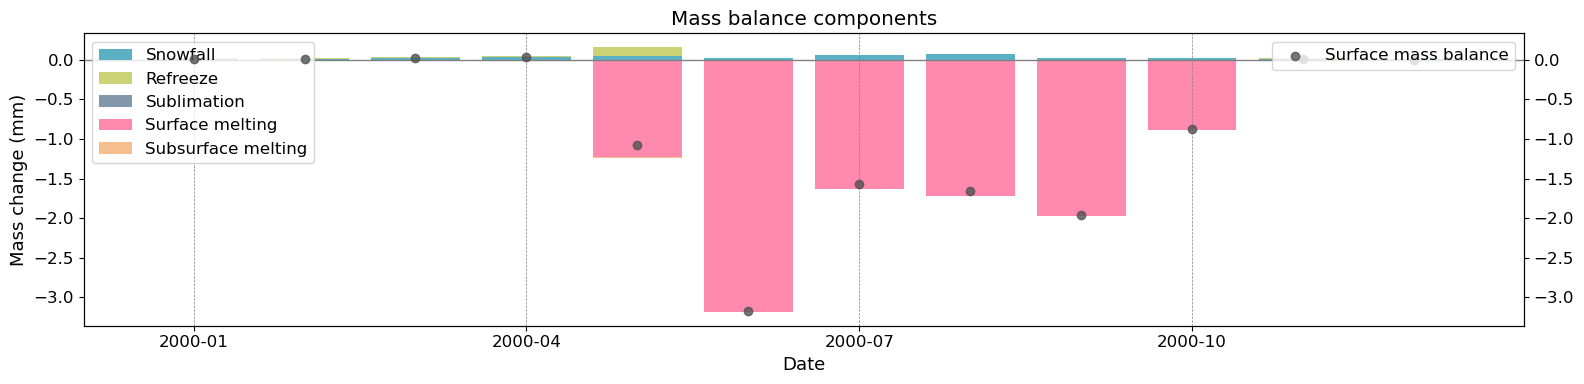

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# 假设 df_month 已经存在
# 设置时间戳为 x 轴
timestamps = df_month['year_month']

# 设置全局字体大小为12
plt.rcParams['font.size'] = 12  # 设置全局字体大小
plt.rcParams['axes.labelsize'] = 13  # 设置坐标轴标签字体大小

plt.rcParams['font.family'] = 'Arial'

# 设置饱和度适中的调色板
colors = {
    'SNOWFALL': '#5cb0c3',  # 温和的中蓝色
    'REFREEZE': '#ccd376',  # 柔和的中绿色
    'SUBLIMATION': '#8498ab',  # 温暖的橙色
    'surfM': '#FF8AAE',  # 中等鲜艳的红色
    'subM': '#f5be8f',  # 柔和的紫色
    'surfMB': '#525252'  # 深灰色
}

# 创建堆积柱状图
fig, ax = plt.subplots(figsize=(16, 4))

ax.bar(timestamps, df_month['SNOWFALL'], label='Snowfall', color=colors['SNOWFALL'])
ax.bar(timestamps, df_month['REFREEZE'], bottom=df_month['SNOWFALL'], label='Refreeze', color=colors['REFREEZE'])
ax.bar(timestamps, df_month['SUBLIMATION'], bottom=0, label='Sublimation', color=colors['SUBLIMATION'])
ax.bar(timestamps, -df_month['surfM'], bottom=df_month['SUBLIMATION'], label='Surface melting', color=colors['surfM'])
ax.bar(timestamps, -df_month['subM'], bottom=df_month['SUBLIMATION'] - df_month['surfM'], label='Subsurface melting', color=colors['subM'])

# 创建第二个 y 轴 (ax2)，共享 x 轴
ax2 = ax.twinx()

# 在 ax2 上添加散点图
ax2.scatter(timestamps, df_month['MB'], label='Surface mass balance', color=colors['surfMB'], alpha=0.8)
#ax2.scatter(df_month['year_month'], df_month['MB'], label='Total mass balance', color='red', marker='x', alpha=0.9)  # 更换蓝色并添加透明度


ax2.set_ylim(ax.get_ylim())

# 设置标题和标签
ax.set_title('Mass balance components')
ax.set_xlabel('Date')
ax.set_ylabel('Mass change (mm)')
ax.axhline(y=0, color='gray', linestyle='-', linewidth=1)  # 添加 y=0 的横线

# 添加图例（合并两个图例）
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

# 设置 X 轴的 tick 间隔（比如每隔 3 个标签显示一个）
ax.set_xticks(timestamps[::3])  # 每隔 3 个时间点显示一个标签
ax.set_xticklabels(timestamps[::3])  # 不旋转标签

# 添加竖直的网格线
ax.grid(True, axis='x', linestyle='--', linewidth=0.5, color='gray')  # 竖直网格线

# 显示图表
plt.tight_layout()
plt.show()


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

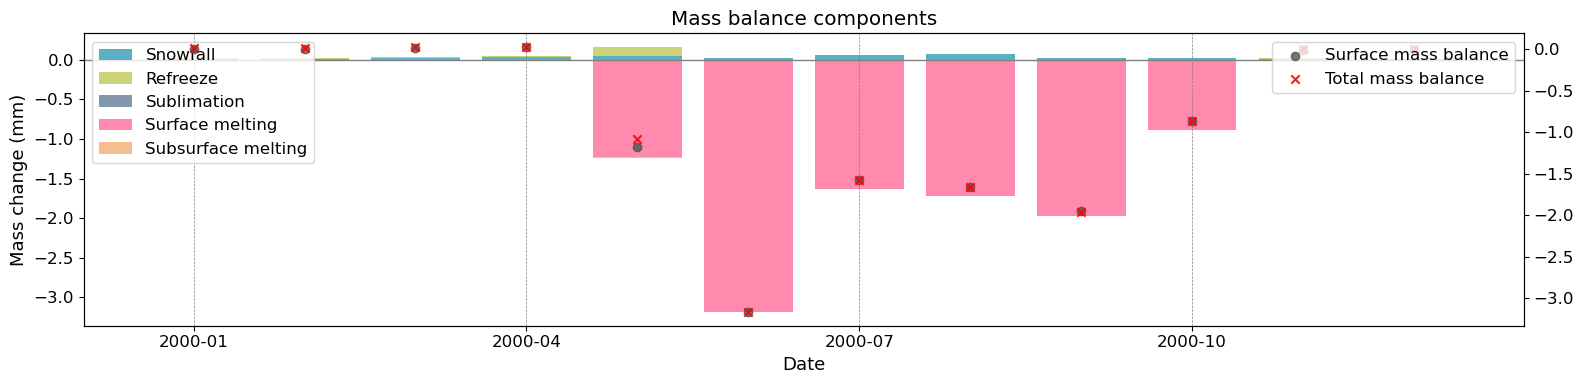

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# 假设 df_month 已经存在
# 设置时间戳为 x 轴
timestamps = df_month['year_month']
timestamps = df_month['year_month']

# 设置全局字体大小为12
plt.rcParams['font.size'] = 12  # 设置全局字体大小
plt.rcParams['axes.labelsize'] = 13  # 设置坐标轴标签字体大小

plt.rcParams['font.family'] = 'Arial'

# 设置饱和度适中的调色板
colors = {
    'SNOWFALL': '#5cb0c3',  # 温和的中蓝色
    'REFREEZE': '#ccd376',  # 柔和的中绿色
    'SUBLIMATION': '#8498ab',  # 温暖的橙色
    'surfM': '#FF8AAE',  # 中等鲜艳的红色
    'subM': '#f5be8f',  # 柔和的紫色
    'surfMB': '#525252'  # 深灰色
}

# 创建堆积柱状图
fig, ax = plt.subplots(figsize=(16, 4))

ax.bar(timestamps, df_month['SNOWFALL'], label='Snowfall', color=colors['SNOWFALL'])
ax.bar(timestamps, df_month['REFREEZE'], bottom=df_month['SNOWFALL'], label='Refreeze', color=colors['REFREEZE'])
ax.bar(timestamps, df_month['SUBLIMATION'], bottom=0, label='Sublimation', color=colors['SUBLIMATION'])
ax.bar(timestamps, -df_month['surfM'], bottom=df_month['SUBLIMATION'], label='Surface melting', color=colors['surfM'])
ax.bar(timestamps, -df_month['subM'], bottom=df_month['SUBLIMATION'] - df_month['surfM'], label='Subsurface melting', color=colors['subM'])

# 创建第二个 y 轴 (ax2)，共享 x 轴
ax2 = ax.twinx()

# 在 ax2 上添加散点图
ax2.scatter(timestamps, df_month['surfMB'], label='Surface mass balance', color=colors['surfMB'], alpha=0.8)
ax2.scatter(timestamps, df_month['MB'], label='Total mass balance', color='red', marker='x', alpha=0.9)  # 更换蓝色并添加透明度

# 设置标题和标签
ax.set_title('Mass balance components')
ax.set_xlabel('Date')
ax.set_ylabel('Mass change (mm)')
ax.axhline(y=0, color='gray', linestyle='-', linewidth=1)  # 添加 y=0 的横线

# 添加图例（合并两个图例）
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

# 设置 X 轴的 tick 间隔（比如每隔 3 个标签显示一个）
ax.set_xticks(timestamps[::3])  # 每隔 3 个时间点显示一个标签
ax.set_xticklabels(timestamps[::3])  # 不旋转标签

# 添加竖直的网格线
ax.grid(True, axis='x', linestyle='--', linewidth=0.5, color='gray')  # 竖直网格线

# 显示图表
plt.tight_layout()
plt.show()


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

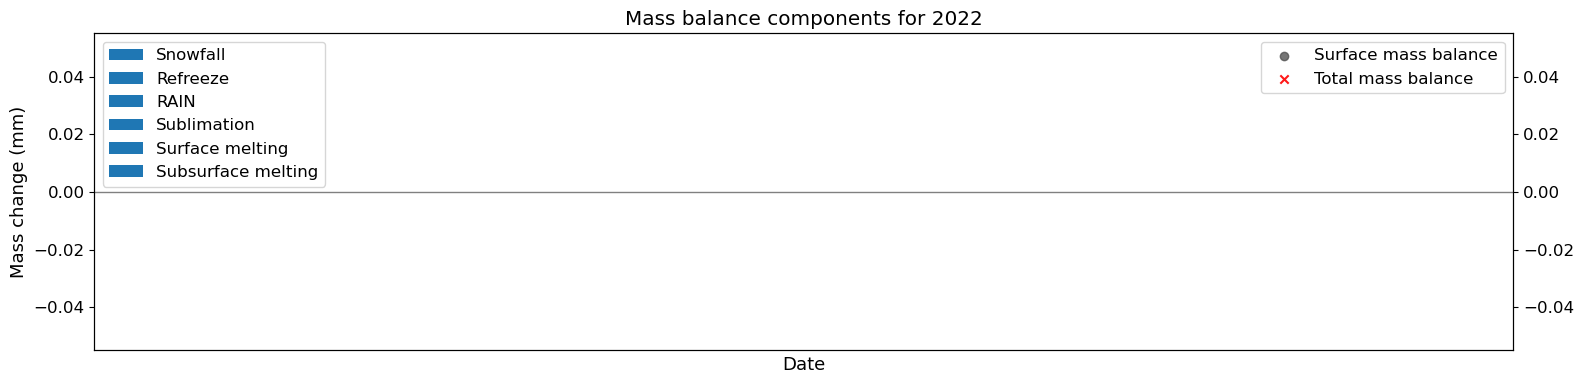

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# 假设 df_day 已经存在，并且 'time' 列已经是 datetime 类型
# 如果 'time' 列不是 datetime 类型，请使用以下语句转换
# df_day['time'] = pd.to_datetime(df_day['time'])

# 过滤数据以仅保留2022年的数据
df_day_2022 = df_day[(df_day['time'] >= '2021-01-01') & (df_day['time'] < '2022-01-01')]

# 设置全局字体大小为12
plt.rcParams['font.size'] = 12  # 设置全局字体大小
plt.rcParams['axes.labelsize'] = 13  # 设置坐标轴标签字体大小
plt.rcParams['font.family'] = 'Arial'

# 设置饱和度适中的调色板
colors = {
    'SNOWFALL': '#5cb0c3',  # 温和的中蓝色
    'REFREEZE': '#ccd376',  # 柔和的中绿色
    'SUBLIMATION': '#8498ab',  # 温暖的橙色
    'surfM': '#FF8AAE',  # 中等鲜艳的红色
    'subM': '#f5be8f',  # 柔和的紫色
    'surfMB': '#525252'  # 深灰色
}

# 创建堆积柱状图
fig, ax = plt.subplots(figsize=(16, 4))

ax.bar(df_day_2022['time'], df_day_2022['SNOWFALL'], label='Snowfall', color=colors['SNOWFALL'])
ax.bar(df_day_2022['time'], df_day_2022['REFREEZE'], 
       bottom=df_day_2022['SNOWFALL'], label='Refreeze', color=colors['REFREEZE'])
ax.bar(df_day_2022['time'], df_day_2022['RAIN']/1000, 
       bottom=df_day_2022['SNOWFALL']+df_day_2022['REFREEZE'], label='RAIN', color='blue')
ax.bar(df_day_2022['time'], df_day_2022['SUBLIMATION'], 
       bottom=0, label='Sublimation', color=colors['SUBLIMATION'])
ax.bar(df_day_2022['time'], -df_day_2022['surfM'], 
       bottom=df_day_2022['SUBLIMATION'], label='Surface melting', color=colors['surfM'])
ax.bar(df_day_2022['time'], -df_day_2022['subM'], 
       bottom=df_day_2022['SUBLIMATION'] - df_day_2022['surfM'], label='Subsurface melting', color=colors['subM'])

# 创建第二个 y 轴 (ax2)，共享 x 轴
ax2 = ax.twinx()

# 在 ax2 上添加散点图
ax2.scatter(df_day_2022['time'], df_day_2022['surfMB'], 
            label='Surface mass balance', color=colors['surfMB'], alpha=0.8)
ax2.scatter(df_day_2022['time'], df_day_2022['MB'], 
            label='Total mass balance', color='red', marker='x', alpha=0.9)

# 设置标题和标签
ax.set_title('Mass balance components for 2022')
ax.set_xlabel('Date')
ax.set_ylabel('Mass change (mm)')
ax.axhline(y=0, color='gray', linestyle='-', linewidth=1)  # 添加 y=0 的横线

# 添加图例（合并两个图例）
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

# 设置 X 轴的 tick 间隔（比如每隔一定的数量显示一个标签）
ax.set_xticks(df_day_2022['time'][::10])  # 每10个时间点显示一个标签
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')  # 旋转标签

# 添加竖直的网格线
ax.grid(True, axis='x', linestyle='--', linewidth=0.5, color='gray')  # 竖直网格线

# 显示图表
plt.tight_layout()
plt.show()


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

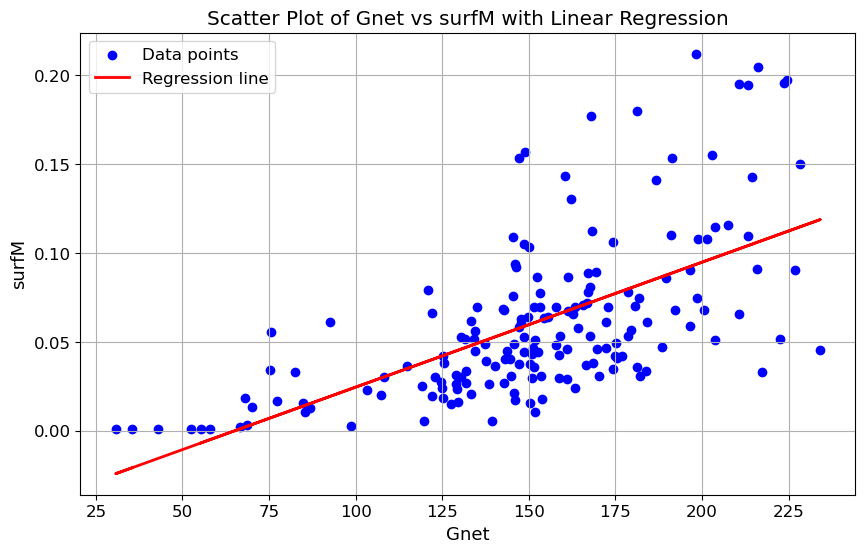

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

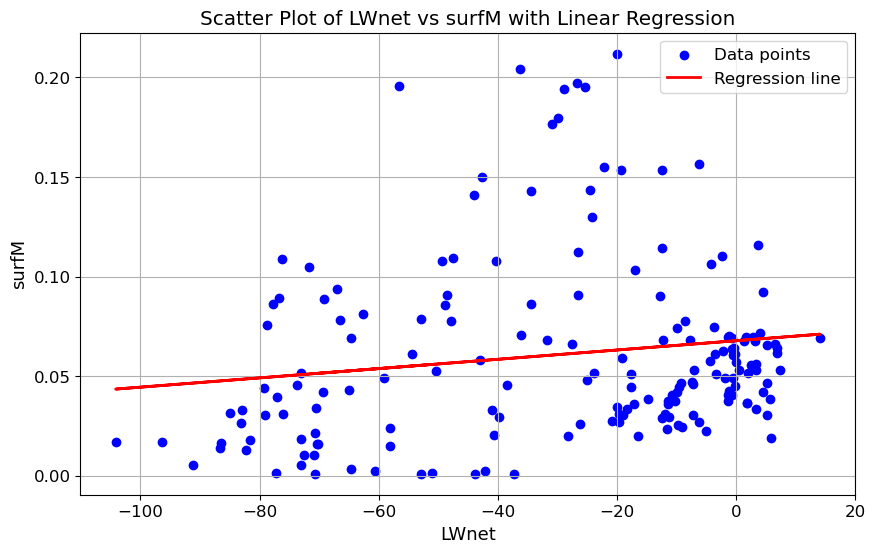

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

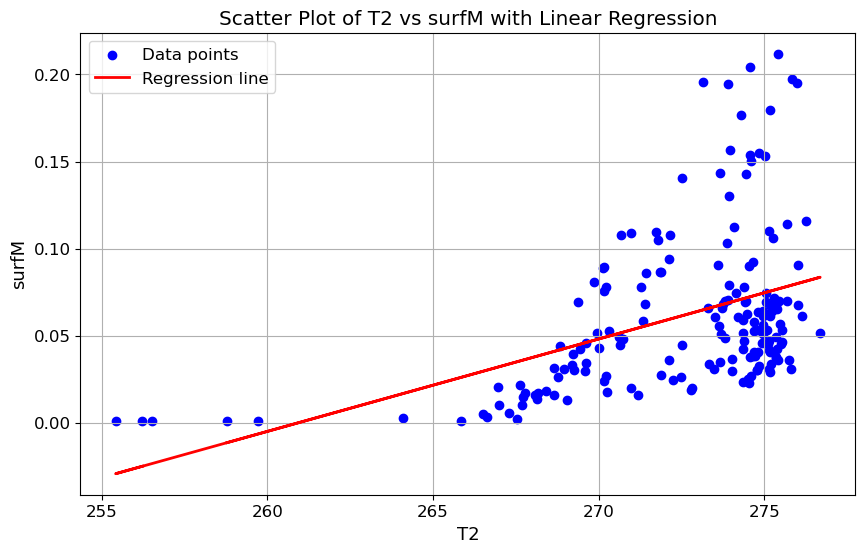

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

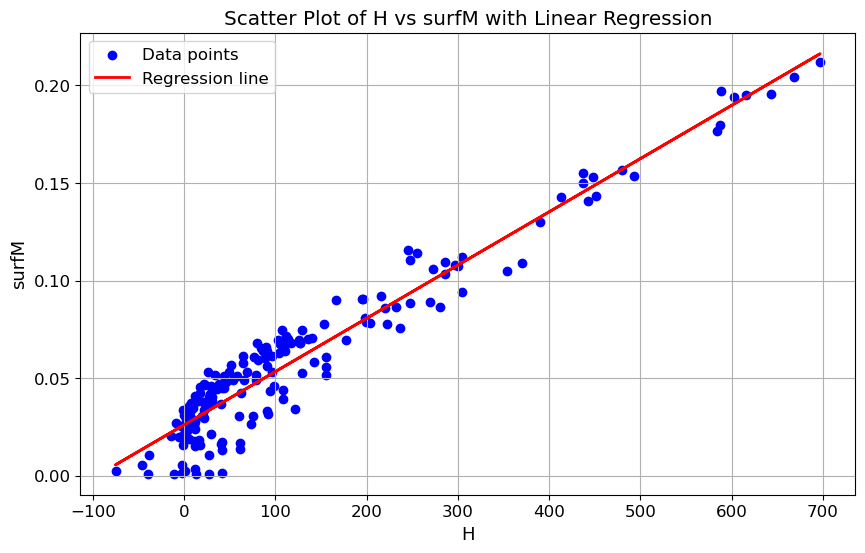

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

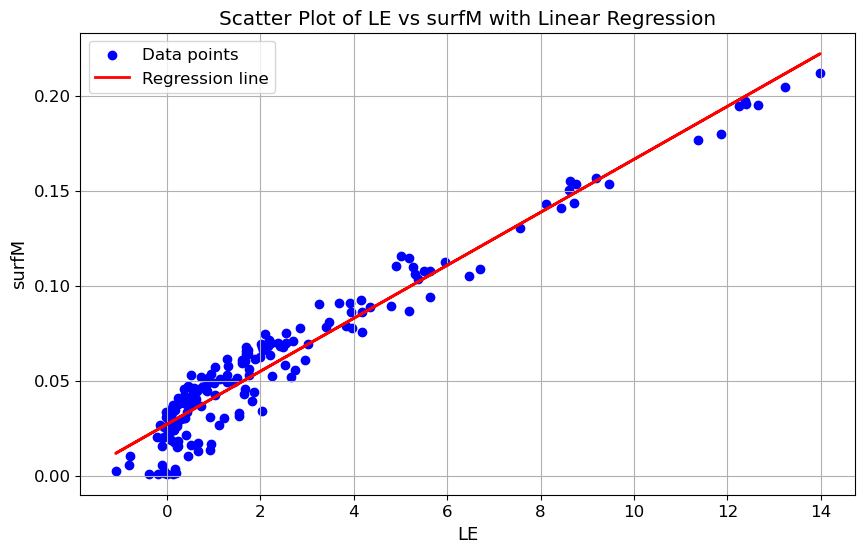

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

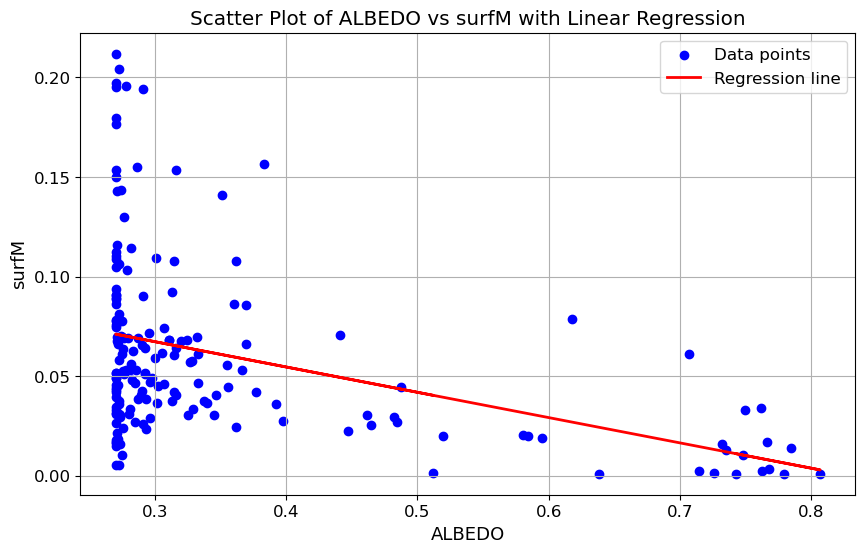

In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import pandas as pd

# 假设 df_day 是一个 Pandas DataFrame，先确认
# 例如，您可以用以下方式加载数据：
# df_day = pd.read_csv('your_data.csv')
df_day['Gnet'] = df_day['G']*(1-df_day['ALBEDO'])
df_day['LWnet'] = df_day['LWin']+df_day['LWout']

# 定义要分析的变量列表
variables = ['Gnet', 'LWnet', 'T2', 'H', 'LE','ALBEDO']

# 循环处理每个变量
for var in variables:
    # 提取数据
    x = df_day[var].values
    
    # 确保通过选择条件获得 y 值，并过滤 x 值
    mask = df_day['surfM'].values > 0.001
    y = df_day['surfM'].values[mask]
    x_filtered = x[mask]  # 也要过滤对应的 x 值

    # 检查是否有足够的数据点
    if len(x_filtered) == 0 or len(y) == 0:
        print(f"Not enough data points for {var}. Skipping...")
        continue

    # 创建散点图
    plt.figure(figsize=(10, 6))
    plt.scatter(x_filtered, y, color='blue', label='Data points')

    # 进行线性回归
    # 确保 x 为二维数组，以适配 sklearn
    X = x_filtered.reshape(-1, 1)
    model = LinearRegression()
    model.fit(X, y)

    # 获取线性回归的预测值
    y_pred = model.predict(X)

    # 绘制回归线
    plt.plot(x_filtered, y_pred, color='red', linewidth=2, label='Regression line')

    # 添加标签和图例
    plt.xlabel(var)
    plt.ylabel('surfM')
    plt.title(f'Scatter Plot of {var} vs surfM with Linear Regression')
    plt.legend()
    plt.grid()

    # 显示图形
    plt.show()


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

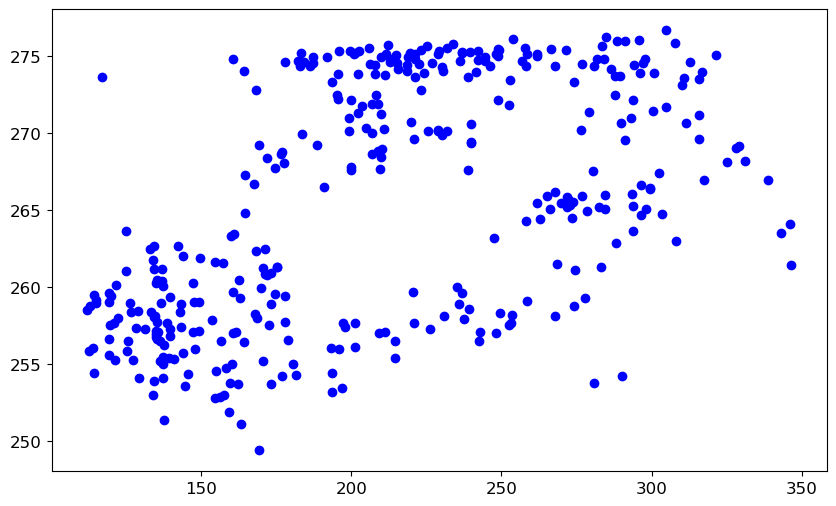

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df_day['G'], df_day['T2'], color='blue', label='Data points')

/tmp/ipykernel_191890/2516337701.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Gnet'] = df['G'] * (1 - df['ALBEDO'])
/tmp/ipykernel_191890/2516337701.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['surfM_groups'] = pd.qcut(df['surfM'], 4, labels=False)
/tmp/ipykernel_191890/2516337701.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

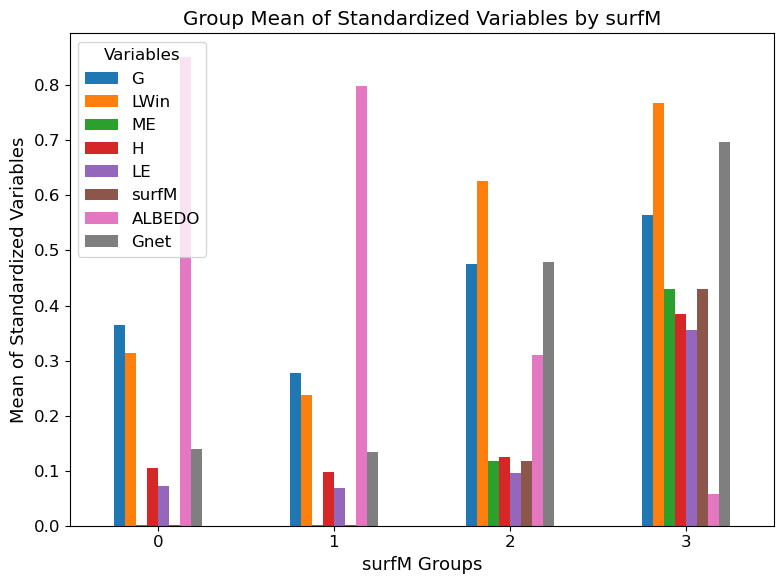

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# 定义要分析的变量列表
variables = ['G', 'LWin', 'ME', 'H', 'LE', 'surfM', 'ALBEDO']
df = df_day[variables]
df['Gnet'] = df['G'] * (1 - df['ALBEDO'])

# 对 surfM 进行分组
df['surfM_groups'] = pd.qcut(df['surfM'], 4, labels=False)

# 对数据进行标准化
scaler = MinMaxScaler()  # 也可选用其他标准化方法，如 StandardScaler()
df[variables + ['Gnet']] = scaler.fit_transform(df[variables + ['Gnet']])

# 分组后计算各组各变量的平均值
grouped = df.groupby('surfM_groups').mean()

# 绘制平均值的柱状图
grouped.plot(kind='bar', figsize=(8, 6))
plt.title('Group Mean of Standardized Variables by surfM')
plt.xlabel('surfM Groups')
plt.ylabel('Mean of Standardized Variables')
plt.xticks(rotation=0)  # 使 x 轴标签水平
plt.legend(title='Variables', loc='best')
plt.tight_layout()  # 自动调整子图参数，以给出指定的间距
plt.show()
